# EDA with AML Datasets

In [1]:
## Check core SDK version number
import azureml.core
import mlflow
import os

from azureml.core import (Datastore, Dataset, Environment, Experiment, ScriptRunConfig,
                          Workspace)
from azureml.core.authentication import InteractiveLoginAuthentication
from IPython.display import display



print("[INFO] SDK version:", azureml.core.VERSION)

## due to diferent tenant -> typically customer tenant
# interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")

ws = Workspace.from_config()
print("[SUCCESS] LOGGED IN: ",ws.name, ws.resource_group, ws.location, ws.subscription_id, sep=' @ ')

## set mlflow backend to AML
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

print("[INFO] MLFlow wired to AML:", "experiments.azureml.net" in mlflow.get_tracking_uri())

[INFO] SDK version: 1.17.0
[SUCCESS] LOGGED IN:  @ mlops-demo @ mlops-rg @ westeurope @ 6ee947fa-0d77-4915-bf68-4a83a8bec2a4
[INFO] MLFlow wired to AML: True


## Config

In [2]:
aml_compute = "aml-cluster"
aml_ds = "aml_data"# "mmaadlsgen2_test"
# aml_dset = 'noa_weather'
# aml_dset = "oj_sample_data"
aml_dset = "diabetes_multiple"
aml_experiment = "mlflow-azureml"
loc_data = "data/demo_data"

In [4]:
## set the datastore
ds = ws.datastores[aml_ds]
print(f"[INFO] Datastore: {ds.name}, type: {ds.datastore_type}")

[INFO] Datastore: aml_data, type: AzureBlob


##  EDA

In [6]:
wtds = Dataset.get_by_name(ws, name=aml_dset)
pdf = wtds.to_pandas_dataframe()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
Y      442 non-null int64
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

In [6]:
# !pip install seaborn

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [8]:
df = pdf.copy()

In [10]:
# eda_target = "Revenue"

## Weather
# eda_target = "temperature"
# categorical_features_list = ['usaf', 'wban','stationName', 'countryOrRegion', 'p_k',
#        'year', 'day', 'version', 'month', eda_target]
# quantitative_features_list = ['latitude', 'longitude', 'elevation',
#        'windAngle', 'windSpeed', eda_target]

## Diabetes
eda_target = 'Y'

categorical_features_list = ['SEX', eda_target]
quantitative_features_list = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', eda_target]


In [11]:
cols_to_drop = [] # or empty
cols_at_end = [eda_target]

Let's just remove [] and the features with 30% or less NaN values

In [12]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]

for c in cols_to_drop:
    del df2[c]
    
# del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')

df2 = df2[[c for c in df2 if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df2]]

df = df2

List of dropped columns: 



In [13]:
df.columns

Index(['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y'], dtype='object')

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: Y, dtype: float64


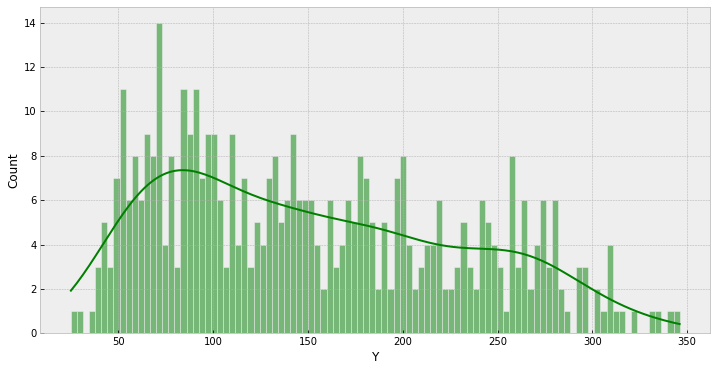

In [14]:
print(df[eda_target].describe())
plt.figure(figsize=(12, 6))
sns.histplot(df[eda_target], color='g', bins=100, kde=True);

#### Numerical data distribution

In [15]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64')]

In [16]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/anaconda/envs/azureml_py3

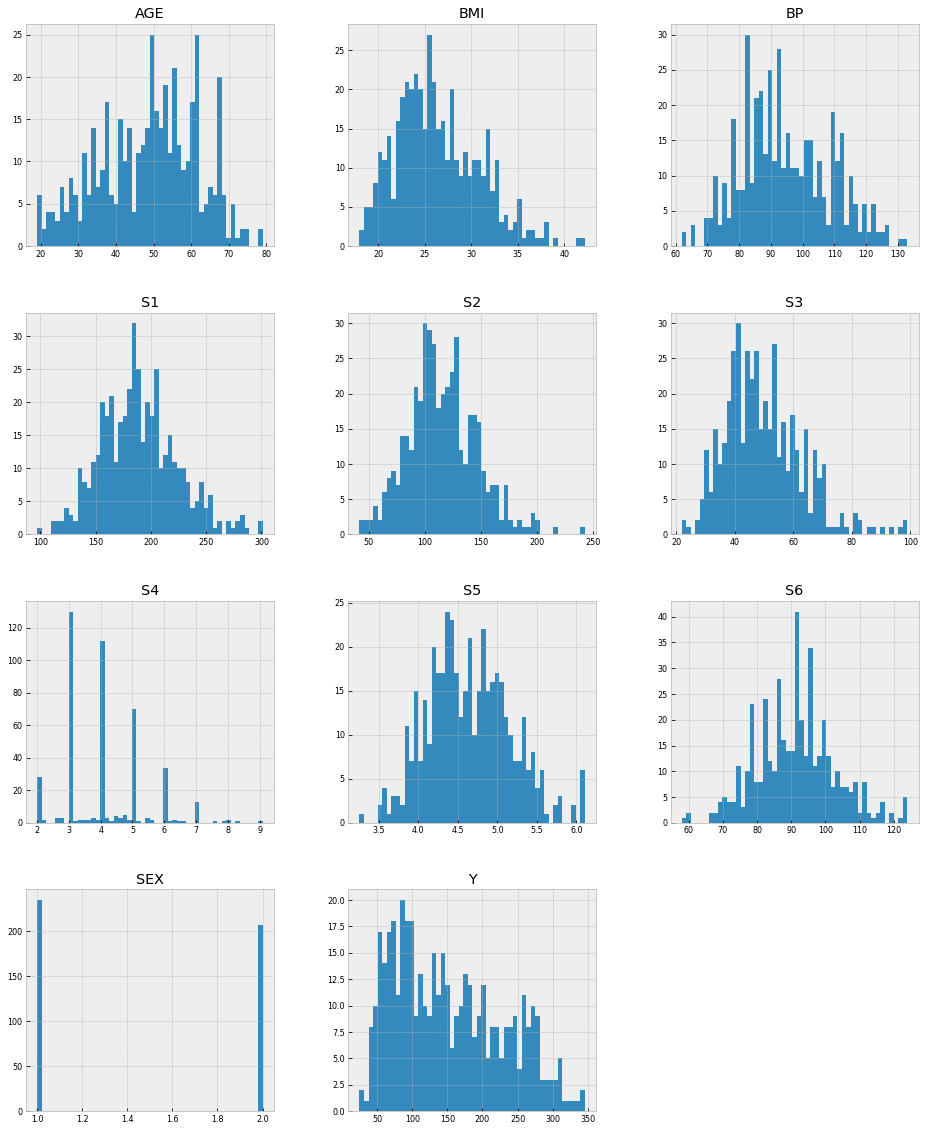

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

#### Correlation

In [18]:
df_num_corr = df_num.corr()[eda_target][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Target {}:\n{}".format(len(golden_features_list), eda_target,golden_features_list))

There is 2 strongly correlated values with Target Y:
BMI    0.586450
S5     0.565883
Name: Y, dtype: float64


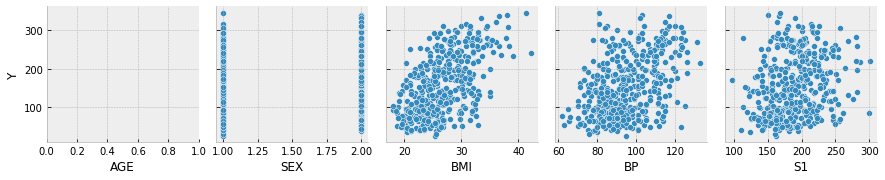

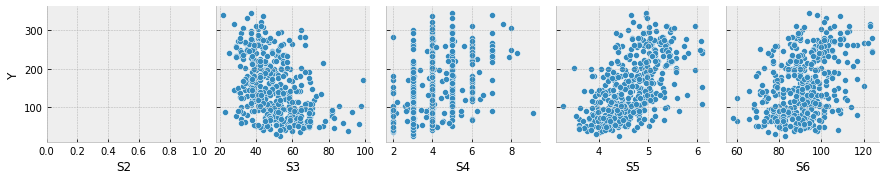

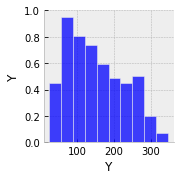

In [19]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=[eda_target])

In [20]:
golden_features_list

BMI    0.586450
S5     0.565883
Name: Y, dtype: float64

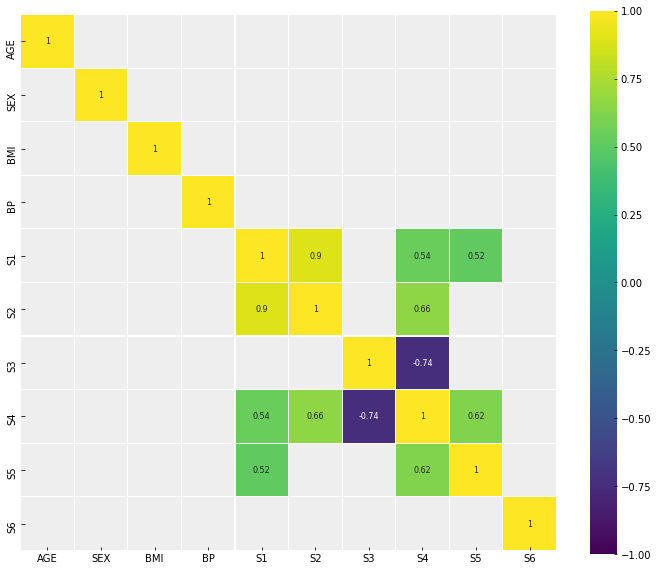

In [21]:
corr = df_num.drop(eda_target, axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### Q -> Q (Quantitative to Quantitative relationship)

In [22]:

df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [23]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append(eda_target)
features_to_analyse

['BMI', 'S5', 'Y']

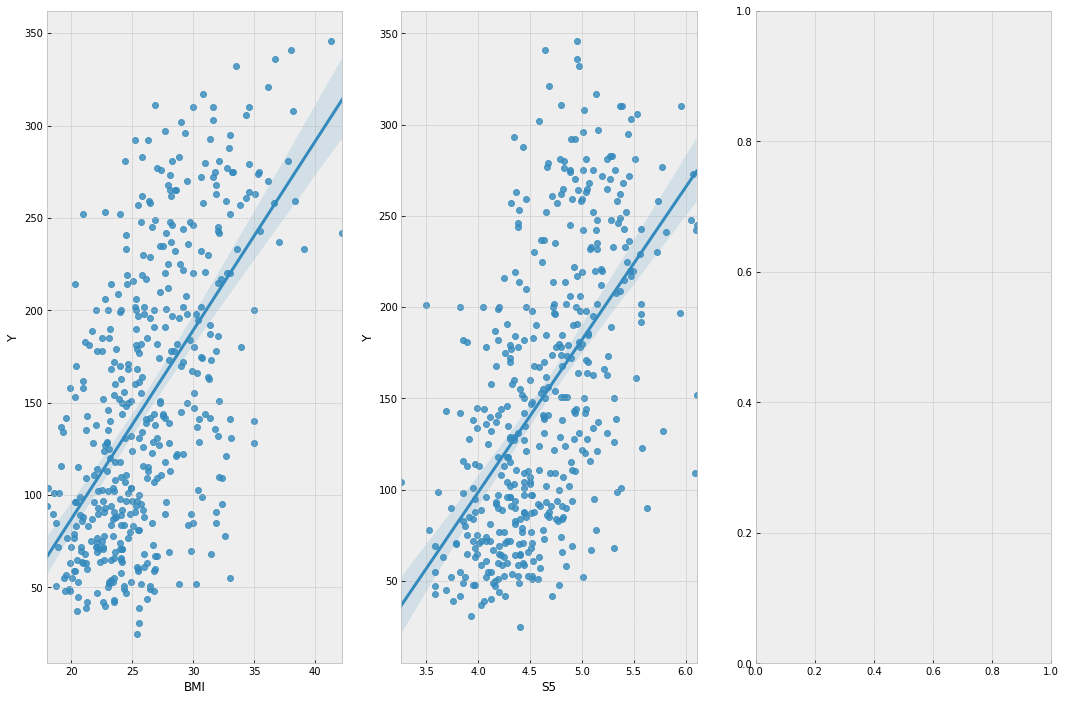

In [24]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y=eda_target, data=df[features_to_analyse], ax=ax)

#### C -> Q (Categorical to Quantitative relationship)

In [25]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

,SEX,Y
0,2,151
1,1,75
2,2,141
3,1,206
4,1,135


In [26]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 0 non numerical features including:
[]


In [30]:
features_to_analyse = categorical_features_list
# features_to_analyse.append(eda_target)

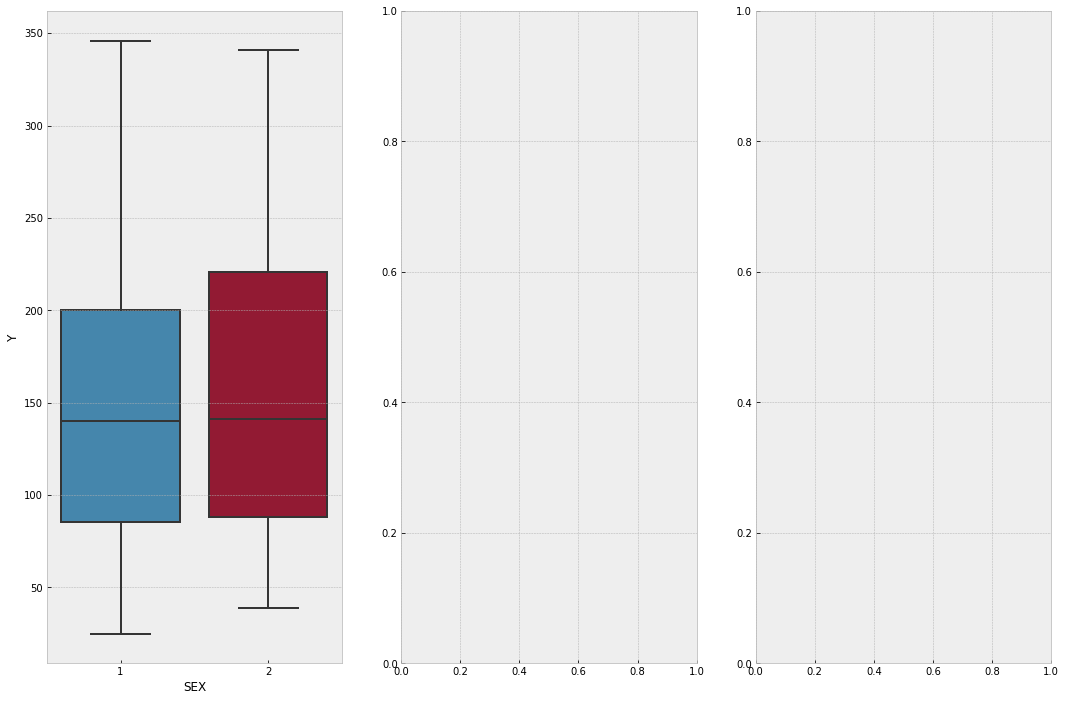

In [32]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.boxplot(x=features_to_analyse[i], y=eda_target, data=df_categ[features_to_analyse], ax=ax)

In [33]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

<Figure size 864x2160 with 0 Axes>

## Done

In [34]:
print("Done.")


Done.
